In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import utils # stuff I've written for this project

import os, sys, datetime, glob, re
import os.path as op

import numpy as np
np.set_printoptions(precision=4)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import shutil

import nibabel as nib

import nilearn
from nilearn.masking import apply_mask
from nilearn.plotting import plot_img, plot_epi, plot_roi, plot_stat_map, view_img, plot_anat
from nilearn.image import load_img, threshold_img, math_img, resample_to_img, new_img_like
from nilearn.input_data import NiftiMasker

import nitime
import nitime.fmri.io as nfio
import nitime.timeseries as ts
import nitime.analysis as nta
import nitime.utils as ntu
import nitime.viz as ntv

import scipy

from bids import BIDSLayout

In [3]:
%matplotlib inline

In [4]:
print(' numpy: ', np.__version__, '\n',
      'nibabel: ', nib.__version__, '\n',
      'nilearn: ', nilearn.__version__, '\n',
      'nitime: ', nitime.__version__, '\n',
      'scipy: ', scipy.__version__)

 numpy:  1.17.5 
 nibabel:  3.1.1 
 nilearn:  0.6.2 
 nitime:  0.8.1 
 scipy:  1.2.1


### Initial definitions (before any preprocessing)

In [5]:
sub = "NB"
ses = "20200929"

raw_data_dir = os.path.abspath("/Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/")
raw_layout = BIDSLayout(raw_data_dir, validate=False, derivatives=False)
derivs_dir = os.path.abspath('/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams')
out_dir = os.path.abspath(f"{derivs_dir}/sub-{sub}")
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

//anaconda/envs/py37mri/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


### Begin Preprocessing

#### Make ref_vol from first dicom

In [ ]:
first_dicom = "/Users/smerdis/data/LGN/Nb_20200929/Silver_Arjun\ -\ 1/mb_bold_mb3_1p75mm_PSN_5/IM-0005-0001.dcm"
# first_dicom = "/Users/smerdis/data/LGN/Nb_20191221/Silver_Arjun - 1/sb_bold_1p75mmISO_PSN_6/IM-0006-0001.dcm"

In [ ]:
!ls {first_dicom}

In [ ]:
!pwd

In [ ]:
dcm2niix_cmd = f"dcm2niix -v 2 -s y -f {ref_vol_name} -z y -o {out_dir} {first_dicom}"
print(dcm2niix_cmd)
os.system(dcm2niix_cmd)

In [ ]:
!ls {out_dir}

### Define refence volume

In [6]:
ref_vol_name = f"sub-{sub}_ses-{ses}_refvol"
ref_vol_path = os.path.abspath(f"{out_dir}/{ref_vol_name}.nii.gz")
ref_vol_img = load_img(ref_vol_path)

#### mcflirt the bold files using ref_vol as the reference image, save them as _preproc

In [7]:
raw_bolds = sorted([f for f in raw_layout.get(subject=sub, session=ses, suffix='bold',
            extension=['nii.gz'], return_type='file')])

In [8]:
print("\n".join(raw_bolds))

/Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20200929/func/sub-NB_ses-20200929_task-conn_run-01_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20200929/func/sub-NB_ses-20200929_task-conn_run-02_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20200929/func/sub-NB_ses-20200929_task-conn_run-03_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20200929/func/sub-NB_ses-20200929_task-conn_run-04_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20200929/func/sub-NB_ses-20200929_task-conn_run-05_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20200929/func/sub-NB_ses-20200929_task-conn_run-06_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20200929/func/sub-NB_ses-20200929_task-conn_run-07_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20200929/func/sub-NB_ses-20200929_task-conn_run-08_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20200929/func/sub-NB_ses-202

In [9]:
for this_epi in raw_bolds:
    align_to = 'refvol' #'refvol' # or 'anat'
    epi_name = os.path.basename(this_epi)
    epi_stub = epi_name.split('.')[0]
    epi_stub_parts = epi_stub.split('_')
    epi_stub_parts.insert(-1, 'desc-preproc')
    epi_stub_mcf = '_'.join(epi_stub_parts)
    if not os.path.isdir(os.path.join(out_dir, f"ses-{ses}", "func")):
        os.makedirs(os.path.join(out_dir, f"ses-{ses}", "func"))
    full_outpath = os.path.join(out_dir, f"ses-{ses}", "func", epi_stub_mcf)
    if align_to == 'refvol':
        mcflirt_cmd = f"mcflirt -reffile {ref_vol_path} -mats -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {full_outpath}"
    elif align_to == 'anat':
        mcflirt_cmd = f"mcflirt -reffile {anat_file} -mats -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {full_outpath}_anatalign"
    print(mcflirt_cmd)
    os.system(mcflirt_cmd)

mcflirt -reffile /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20200929_refvol.nii.gz -mats -plots -report -cost mutualinfo -smooth 16 -in /Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20200929/func/sub-NB_ses-20200929_task-conn_run-01_bold.nii.gz -o /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/ses-20200929/func/sub-NB_ses-20200929_task-conn_run-01_desc-preproc_bold
mcflirt -reffile /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20200929_refvol.nii.gz -mats -plots -report -cost mutualinfo -smooth 16 -in /Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20200929/func/sub-NB_ses-20200929_task-conn_run-02_bold.nii.gz -o /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/ses-20200929/func/sub-NB_ses-20200929_task-conn_run-02_desc-preproc_bold
mcflirt -reffile /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20200929_refvol.nii.gz -mats -plots -repor

In [22]:
!ls /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB

fmri2struct.mat
refvol2t1.nii.gz
ses-20191221
ses-20200929
struct2fmri.mat
sub-NB_ses-20191221_desc-LLGNsmallM80_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmallP80_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmall_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmall_space-T1w_roi.nii.gz
sub-NB_ses-20191221_desc-RLGNbigM80_roi.nii.gz
sub-NB_ses-20191221_desc-RLGNbigP80_roi.nii.gz
sub-NB_ses-20191221_desc-RLGNbig_roi.nii.gz
sub-NB_ses-20191221_desc-RLGNbig_space-T1w_roi.nii.gz
sub-NB_ses-20191221_mask.nii.gz
sub-NB_ses-20191221_refvol.json
sub-NB_ses-20191221_refvol.nii.gz
sub-NB_ses-20200929_refvol.json
sub-NB_ses-20200929_refvol.nii.gz


#### Move event and json files

In [ ]:
events_glob = f"{raw_data_dir}/ses-{ses}/func/*events*.tsv"
print("\n".join(glob.glob(events_glob)))
task_json_glob = f"{raw_data_dir}/ses-{ses}/func/*task*json"
print("\n".join(glob.glob(task_json_glob)))

### Define paths etc

In [7]:
!ls /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB

fmri2struct.mat
lgnfmri2t1.mat
lgnfmri2t1.nii.gz
mb3fmri2t1.mat
mb3refvol2t1.nii.gz
refvol2t1.nii.gz
ses-20191221
ses-20200929
struct2fmri.mat
sub-NB_ses-20191221_desc-LLGNsmallM80_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmallM80_space-T1w_nilearn_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmallM80_space-T1w_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmallP80_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmallP80_space-T1w_nilearn_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmallP80_space-T1w_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmall_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmall_space-T1w_nilearn_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmall_space-T1w_roi.nii.gz
sub-NB_ses-20191221_desc-RLGNbigM80_roi.nii.gz
sub-NB_ses-20191221_desc-RLGNbigM80_space-T1w_nilearn_roi.nii.gz
sub-NB_ses-20191221_desc-RLGNbigM80_space-T1w_roi.nii.gz
sub-NB_ses-20191221_desc-RLGNbigP80_roi.nii.gz
sub-NB_ses-20191221_desc-RLGNbigP80_space-T1w_nilearn_roi.nii.gz
sub-NB_ses-20191221_desc-RLGNbigP80_space-T1w_roi.nii.gz
sub

In [8]:
preproc_layout = BIDSLayout(out_dir, validate=False)
# get only the big LGN masks, not any smaller M/P rois already assigned
rois = [f for f in
        preproc_layout.get(subject=sub, extension=['.nii.gz'], suffix='roi', return_type='file')
        if ("desc-LLGN" in f or "desc-RLGN" in f) and ('T1w' not in f)]
big_rois = [f for f in
        preproc_layout.get(subject=sub, extension=['.nii.gz'], suffix='roi', return_type='file')
        if ("desc-LLGN" in f or "desc-RLGN" in f) and ('P' not in f and 'M' not in f and 'T1w' not in f)]
roi_ref_vol = os.path.abspath(f"{out_dir}/sub-{sub}_ses-20191221_refvol.nii.gz")
mask_file = os.path.join(out_dir, f"sub-{sub}_ses-{ses}_mask.nii.gz")
coh_fn = os.path.join(out_dir, f"sub-{sub}_ses-{ses}_task-hemi_desc-coherence_map.nii")
anat_file = raw_layout.get(subject=sub, session='20191221', extension=['nii.gz'], suffix="T1w", return_type='file')[0]
anat_img = load_img(anat_file)

print("LGN rois (including M/P):", '\n'.join(rois), "LGN rois (LGN only):", '\n'.join(big_rois), "Reference BOLD volume:", ref_vol_path, "ROI refvol: ", roi_ref_vol, "anat file: ", anat_file, sep="\n")

LGN rois (including M/P):
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmall_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallM80_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallP80_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbig_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbigM80_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbigP80_roi.nii.gz
LGN rois (LGN only):
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmall_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbig_roi.nii.gz
Reference BOLD volume:
/Users/smerdis

In [9]:
print(f"fsleyes {anat_file} {ref_vol_path}")

fsleyes /Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20191221/anat/sub-NB_ses-20191221_T1w.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20200929_refvol.nii.gz


### FLIRT to get everything in the same space

#### flirt first MB3 epi to T1

In [12]:
print(out_dir)

/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB


In [13]:
bold_to_t1_xfm_path = f"{out_dir}/mb3fmri2t1.mat"
t1_to_bold_xfm_path = f"{out_dir}/t12mb3fmri.mat"

In [50]:
flirt_cmd = f"flirt -in {ref_vol_path} -ref {anat_file} -omat {bold_to_t1_xfm_path} -out {out_dir}/mb3refvol2t1"
print(flirt_cmd)
os.system(flirt_cmd)

flirt -in /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20200929_refvol.nii.gz -ref /Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20191221/anat/sub-NB_ses-20191221_T1w.nii.gz -omat /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/mb3fmri2t1.mat -out /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/mb3refvol2t1


0

In [51]:
inverse_cmd = f"convert_xfm -omat {t1_to_bold_xfm_path} -inverse {bold_to_t1_xfm_path}"
os.system(inverse_cmd)

0

#### flirt ROIs to T1 using reference volume of LGN scan

In [14]:
!ls {roi_ref_vol}

/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_refvol.nii.gz


In [15]:
roi_to_t1_xfm_path = f"{out_dir}/lgnfmri2t1.mat"
t1_to_roi_xfm_path = f"{out_dir}/t12lgnfmri.mat"

In [54]:
flirt_cmd = f"flirt -in {roi_ref_vol} -ref {anat_file} -omat {roi_to_t1_xfm_path} -out {out_dir}/lgnfmri2t1"
print(flirt_cmd)
os.system(flirt_cmd)

flirt -in /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_refvol.nii.gz -ref /Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20191221/anat/sub-NB_ses-20191221_T1w.nii.gz -omat /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/lgnfmri2t1.mat -out /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/lgnfmri2t1


0

In [55]:
inverse_cmd = f"convert_xfm -omat {t1_to_roi_xfm_path} -inverse {roi_to_t1_xfm_path}"
os.system(inverse_cmd)

0

#### Convert rois to space of structural T1 scan

In [65]:
## 10/9 - this doesn't appear to work right, but the resampling using nilearn below does

In [56]:
for roi in rois:
    roi_fn_parts = roi.split('_')
    roi_fn_parts.insert(-1, 'space-T1w')
    resampled_roi_fn = '_'.join(roi_fn_parts)
    roi_flirt_cmd = f"flirt -ref {anat_file} -in {roi} -applyxfm -init {roi_to_t1_xfm_path} -out\
                {resampled_roi_fn}"
    print(roi_flirt_cmd)
    os.system(roi_flirt_cmd)

flirt -ref /Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20191221/anat/sub-NB_ses-20191221_T1w.nii.gz -in /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmall_roi.nii.gz -applyxfm -init /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/lgnfmri2t1.mat -out                /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmall_space-T1w_roi.nii.gz
flirt -ref /Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20191221/anat/sub-NB_ses-20191221_T1w.nii.gz -in /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallM80_roi.nii.gz -applyxfm -init /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/lgnfmri2t1.mat -out                /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallM80_space-T1w_roi.nii.gz
flirt -ref /Users/smerdis/data/LGN/BIDS/NB_20200929/sub-

In [58]:
print(f"fsleyes {anat_file} {ref_vol_path} {roi_ref_vol}")

fsleyes /Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20191221/anat/sub-NB_ses-20191221_T1w.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20200929_refvol.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_refvol.nii.gz


#### For testing BIDS names

In [59]:
utils.isBIDSFile(mask_file)
utils.isBIDSFile(coh_fn)
utils.isBIDSFile(ref_vol_path)
for roi in rois:
    utils.isBIDSFile(roi)

sub-NB_ses-20200929_mask.nii.gz True
sub-NB_ses-20200929_task-hemi_desc-coherence_map.nii True
sub-NB_ses-20200929_refvol.nii.gz True
sub-NB_ses-20191221_desc-LLGNsmall_roi.nii.gz True
sub-NB_ses-20191221_desc-LLGNsmallM80_roi.nii.gz True
sub-NB_ses-20191221_desc-LLGNsmallP80_roi.nii.gz True
sub-NB_ses-20191221_desc-RLGNbig_roi.nii.gz True
sub-NB_ses-20191221_desc-RLGNbigM80_roi.nii.gz True
sub-NB_ses-20191221_desc-RLGNbigP80_roi.nii.gz True


### Write hemifield event files (they are all identical)

In [ ]:
utils.write_hemifield_localizer_event_file(f"{raw_data_dir}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-hemi_run-01_events.tsv")
utils.write_hemifield_localizer_event_file(f"{raw_data_dir}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-hemi_run-02_events.tsv")

In [ ]:
for e in glob.glob(events_glob):
    fileparts = op.split(e)[-1].split('_')[:-1]
    fileparts[0] = f"sub-{sub}"
    #runpart = fileparts[-2]
    #print('_'.join(fileparts), fileparts[-2])
    fn = '_'.join(fileparts)
    new_file_name = f"{raw_data_dir}/ses-{ses}/func/{fn}.tsv"
    print(e, new_file_name, sep="\n")
    #shutil.copyfile(e, new_file_name)

In [ ]:

for e in glob.glob(task_json_glob):
    fn = os.path.split(e)[-1]
    new_file_name = f"{raw_data_dir}/ses-{ses}/func/{fn}"
    print(e, new_file_name, sep="\n")
    #shutil.copyfile(e, new_file_name)

In [ ]:
blocks_in_order = ['L', 'R']
for thisrun in [1]:
    events_fn = f"{raw_data_dir}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-hemi_run-{thisrun:02d}_events.tsv"
    events_file_contents = f"onset\tduration\ttrial_type\n"
    time_between_onsets = 13.5
    for i in range(22):
        events_file_contents += f"{i*time_between_onsets:.2f}\t{time_between_onsets}\t{blocks_in_order[i%(len(blocks_in_order))]}\n"
    #with open(events_fn, 'w') as f:
        #f.write(events_file_contents)
    print(events_fn, '\n', events_file_contents)

## GLM invocation from a cell

### Individual GLMs

Run the GLMs for each task using all runs

In [ ]:
hemi_workdir = utils.run_fixedeffects_glm(sub, ses, "hemi", [1, 2], raw_data_dir, out_dir)

In [ ]:
hemi_datasink = f"{hemi_workdir}/fixedeffects/modelfit/datasink"
print(hemi_workdir, hemi_datasink, sep="\n")
!ls {hemi_datasink}

In [ ]:
mp_workdir = utils.run_fixedeffects_glm(sub, ses, "mp", [1, 2, 3, 4, 5, 6, 7, 8], raw_data_dir, out_dir)

In [ ]:
mp_datasink = f"{mp_workdir}/fixedeffects/modelfit/datasink"
print(mp_workdir, mp_datasink, sep="\n")
!ls {mp_datasink}

In [ ]:
hemi_RL_l1, hemi_RL_l2 = utils.get_model_outputs(hemi_datasink, [1])
hemi_LR_l1, hemi_LR_l2 = utils.get_model_outputs(hemi_datasink, [2])
mp_l1, mp_l2 = utils.get_model_outputs(mp_datasink, [1])
pm_l1, pm_l2 = utils.get_model_outputs(mp_datasink, [2])
visresp_l1, visresp_l2 = utils.get_model_outputs(mp_datasink, [3])

In [ ]:
#print(f"fsleyes {ref_vol_path} {anat_file} {hemi_LR_l2[0]} {hemi_RL_l2[0]} {mp_l2[0]} {pm_l2[0]}")
print(f"fsleyes {ref_vol_path} {anat_file} {hemi_LR_l2[0]} {hemi_RL_l2[0]} {visresp_l2[0]}")

In [ ]:
beta_RL = hemi_RL_l2[0]
beta_LR = hemi_LR_l2[0]
beta_MP = mp_l2[0]
beta_PM = pm_l2[0]
beta_MP_img = load_img(beta_MP)

In [ ]:
beta_RL, beta_MP

### Grab the affine transformation matrix so we can convert EPI to scanner space

In [16]:
epi_vox_center = (np.array(ref_vol_img.get_fdata().shape) - 1) / 2.
print('epi vox center: ', epi_vox_center)
print(ref_vol_path)

epi vox center:  [59.5 59.5 34. ]
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20200929_refvol.nii.gz


#### resample ROIs

In [17]:
print(ref_vol_img.shape, ref_vol_img.affine, sep='\n')

(120, 120, 69)
[[ -1.75     0.      -0.     105.    ]
 [ -0.       1.6455  -0.5106 -80.3307]
 [  0.       0.5957   1.4104 -46.174 ]
 [  0.       0.       0.       1.    ]]


In [62]:
print(out_dir)

/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB


In [18]:
!ls {out_dir}

fmri2struct.mat
lgnfmri2t1.mat
lgnfmri2t1.nii.gz
mb3fmri2t1.mat
mb3refvol2t1.nii.gz
refvol2t1.nii.gz
ses-20191221
ses-20200929
struct2fmri.mat
sub-NB_ses-20191221_desc-LLGNsmallM80_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmallM80_space-T1w_nilearn_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmallM80_space-T1w_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmallP80_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmallP80_space-T1w_nilearn_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmallP80_space-T1w_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmall_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmall_space-T1w_nilearn_roi.nii.gz
sub-NB_ses-20191221_desc-LLGNsmall_space-T1w_roi.nii.gz
sub-NB_ses-20191221_desc-RLGNbigM80_roi.nii.gz
sub-NB_ses-20191221_desc-RLGNbigM80_space-T1w_nilearn_roi.nii.gz
sub-NB_ses-20191221_desc-RLGNbigM80_space-T1w_roi.nii.gz
sub-NB_ses-20191221_desc-RLGNbigP80_roi.nii.gz
sub-NB_ses-20191221_desc-RLGNbigP80_space-T1w_nilearn_roi.nii.gz
sub-NB_ses-20191221_desc-RLGNbigP80_space-T1w_roi.nii.gz
sub

(128, 128, 21)
[[-1.7500e+00  1.7500e-16 -1.5861e-17  1.1200e+02]
 [ 1.7500e-16  1.7428e+00 -1.5861e-01 -1.0700e+02]
 [ 0.0000e+00  1.5861e-01  1.7428e+00 -2.8631e+01]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00]]
(160, 240, 256)
[[   1.        0.        0.      -77.995 ]
 [   0.        1.        0.     -105.7637]
 [   0.        0.        1.     -144.1988]
 [   0.        0.        0.        1.    ]]
(128, 128, 21)
[[-1.7500e+00  1.7500e-16 -1.5861e-17  1.1200e+02]
 [ 1.7500e-16  1.7428e+00 -1.5861e-01 -1.0700e+02]
 [ 0.0000e+00  1.5861e-01  1.7428e+00 -2.8631e+01]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00]]
(160, 240, 256)
[[   1.        0.        0.      -77.995 ]
 [   0.        1.        0.     -105.7637]
 [   0.        0.        1.     -144.1988]
 [   0.        0.        0.        1.    ]]
(128, 128, 21)
[[-1.7500e+00  1.7500e-16 -1.5861e-17  1.1200e+02]
 [ 1.7500e-16  1.7428e+00 -1.5861e-01 -1.0700e+02]
 [ 0.0000e+00  1.5861e-01  1.7428e+00 -2.8631e+01]
 [ 0.0000e+00 

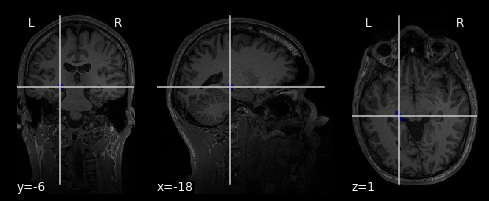

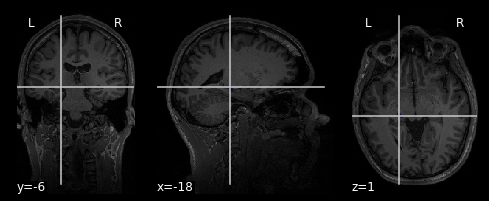

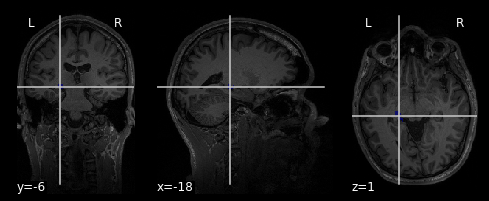

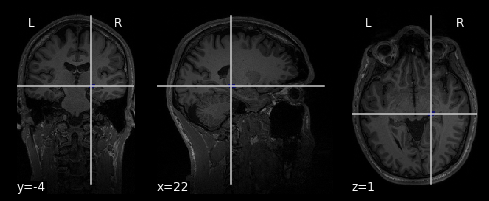

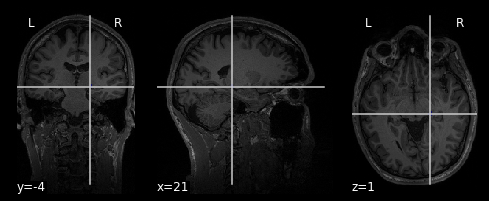

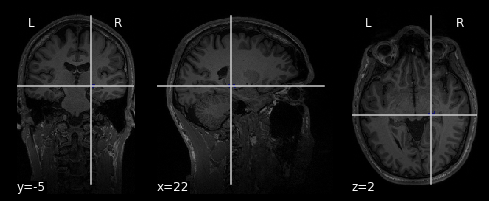

In [77]:
resampled_rois = []
for roi in rois:
    roi_img = load_img(roi)
    print(roi_img.shape, roi_img.affine, sep='\n')
    roi_fn_parts = roi.split('_')
    roi_fn_parts.insert(-1, 'space-T1w_nilearn')
    resampled_roi_fn = '_'.join(roi_fn_parts)
    resampled_roi_img = resample_to_img(roi_img, anat_img, 'nearest')
    resampled_roi_img.to_filename(resampled_roi_fn)
    resampled_rois.append(resampled_roi_fn)
    print(resampled_roi_img.shape, resampled_roi_img.affine, sep='\n')
    plot_roi(resampled_roi_img, bg_img=anat_img)

In [10]:
try:
    if resampled_rois:
        pass
    else:
        resampled_rois = [f for f in
        preproc_layout.get(subject=sub, extension=['.nii.gz'], suffix='roi', return_type='file')
        if ("desc-LLGN" in f or "desc-RLGN" in f) and ('T1w_nilearn' in f)]
except NameError:
    resampled_rois = [f for f in
        preproc_layout.get(subject=sub, extension=['.nii.gz'], suffix='roi', return_type='file')
        if ("desc-LLGN" in f or "desc-RLGN" in f) and ('T1w_nilearn' in f)]
print('\n'.join(resampled_rois))

/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmall_space-T1w_nilearn_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallM80_space-T1w_nilearn_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallP80_space-T1w_nilearn_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbig_space-T1w_nilearn_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbigM80_space-T1w_nilearn_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbigP80_space-T1w_nilearn_roi.nii.gz


### Assign 80/20 or whatever

In [20]:
print(rois)

['/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmall_roi.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallM80_roi.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallP80_roi.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbig_roi.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbigM80_roi.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbigP80_roi.nii.gz']


In [39]:
print(roi_ref_vol)

/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_refvol.nii.gz


In [11]:
for roi in rois:
    utils.roi_stats({roi:load_img(roi)}, load_img(roi_ref_vol))

/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmall_roi.nii.gz
(78, 3)
ROI max and min coords [77 61 14] [72 55 10]
[5 6 4] [2.4359 2.4487 2.1667]
[74.5641 58.5513 11.8333] [-18.4872  -6.8333   1.2789]
****
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallM80_roi.nii.gz
(16, 3)
ROI max and min coords [76 60 13] [72 57 10]
[4 3 3] [1.625  1.0625 1.25  ]
[74.375  58.9375 11.75  ] [-18.1562  -6.147    1.1949]
****
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallP80_roi.nii.gz
(62, 3)
ROI max and min coords [77 61 14] [72 55 10]
[5 6 4] [2.3871 2.5484 2.1452]
[74.6129 58.4516 11.8548] [-18.5726  -7.0104   1.3005]
****
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbig_roi.nii.gz
(47, 3)
ROI max and min coords [54 62 13] [49 57 11]
[5 5 2] [2.7234 2.2979 0.9787]
[51.2766 59.7021 12.0213

Big roi extends from [-14.    -12.732  -2.48 ] to [-22.75   -2.909   5.443]
Extent is [-8.75   9.822  7.923] and center is [-18.487  -6.833   1.279]


TypeError: 'AxesSubplot' object is not subscriptable

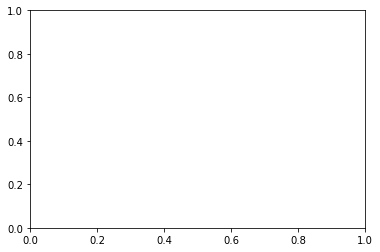

In [49]:
for roi in big_rois:
    big_roi_stub = op.basename(roi).split('_')[-2]
    subdivision_rois = [f for f in rois if big_roi_stub in f and ('P' in f or 'M' in f)]
    utils.roi_centers(roi, subdivision_rois, load_img(roi_ref_vol))

In [42]:
for roi in resampled_rois:
    utils.roi_stats({roi:load_img(roi)}, anat_img)

/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmall_space-T1w_nilearn_roi.nii.gz
(409, 3)
ROI max and min coords [ 64 104 149] [ 55  92 142]
[ 9 12  7] [4.5232 4.9242 3.6161]
[ 59.4768  99.0758 145.3839] [-18.5182  -6.688    1.185 ]
****
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallM80_space-T1w_nilearn_roi.nii.gz
(86, 3)
ROI max and min coords [ 64 102 148] [ 57  96 142]
[7 6 6] [4.1395 2.3372 2.7674]
[ 59.8605  99.6628 145.2326] [-18.1345  -6.101    1.0337]
****
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallP80_space-T1w_nilearn_roi.nii.gz
(323, 3)
ROI max and min coords [ 64 104 149] [ 55  92 142]
[ 9 12  7] [4.6254 5.0805 3.5759]
[ 59.3746  98.9195 145.4241] [-18.6204  -6.8442   1.2253]
****
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbig_space-T1w_nilearn_roi.nii.gz
(

In [ ]:
_, mp_l2 = utils.get_model_outputs(mp_datasink, [1])
beta_MP_img = load_img(beta_MP)

In [ ]:
for roi in big_rois:
    roi_stats({roi:load_img(roi)})
    if 'desc-L' in roi:
        M_roi, P_roi, threshold = utils.assign_roi_percentile(roi, beta_MP, 80, ref_vol_img, 'L')
    elif 'desc-R' in roi:
        M_roi, P_roi, threshold = utils.assign_roi_percentile(roi, beta_MP, 80, ref_vol_img, 'R')
    else:
        print('Error - not sure which hemisphere roi is in')
    roi_stats({'M':load_img(M_roi), 'P':load_img(P_roi)})

### Cross-validation

In [ ]:
# add code to:
# compute threshold statistics (variance etc) across xval runs
# 
def cross_val_glm(sub, ses, task, runs, raw_layout, preproc_layout):
    print(raw_layout, preproc_layout, sep="\n")
    raw_data_dir = raw_layout.root
    out_dir = preproc_layout.root
    working_dirs = []
    for i,r in enumerate(runs):
        other_runs = [*runs[0:i], *runs[i+1:]]
        print(i, r, other_runs)
        wdir = utils.run_fixedeffects_glm(sub, ses, task, other_runs,
                    raw_data_dir, out_dir, working_dir_suffix=f"excrun{r}")
        working_dirs.append(wdir)
    return working_dirs

In [ ]:
# beta_imgs = []
# threshold = 6.0
# for workdir in hemi_xval_outputs:
#     datasink = f"{workdir}/fixedeffects/modelfit/datasink"
#     xval_suffix = op.split(workdir)[-1].split('_')[-1] # e.g. 'excrun1'
#     print("xvalRUN", workdir) #, datasink, sep="\n")
#     #!ls {mp_datasink}
#     l1, l2 = utils.get_model_outputs(datasink, [1])
#     beta = l2[0]
#     beta_img = load_img(beta)
#     print(beta, beta_img.shape)
#     #thresholded_beta = threshold_img(beta_img, threshold, copy=True)
#     bin_beta = math_img(f'img > {threshold}', img=beta_img)
#     bin_beta.to_filename(f"{out_dir}/sub-{sub}_ses-{ses}_hemi_mask_{xval_suffix}_thr{threshold:.0f}.nii.gz")
#     #print(np.count_nonzero(thresholded_beta.get_fdata()), np.count_nonzero(bin_beta.get_fdata()))
#     beta_imgs.append(bin_beta)
# print(beta_imgs)
# intersect_img = nilearn.masking.intersect_masks(beta_imgs, threshold=1)
# intersect_img.to_filename(f"{out_dir}/sub-{sub}-ses-{ses}_hemi_intersect_mask_thr{threshold:.0f}.nii.gz")
# print((np.logical_and(*[b.get_fdata() for b in beta_imgs])).to_filename)

In [ ]:
mp_xval_outputs = cross_val_glm(sub, ses, "mp", [1, 2, 3, 4, 5, 6, 7, 8], raw_layout, preproc_layout)

In [ ]:
mp_xval_outputs

In [ ]:
plt.imshow(ref_vol_img.get_data()[:,:,13])

In [ ]:
thresholds = np.empty((2, len(mp_xval_outputs)))
for (i, mp_workdir) in enumerate(mp_xval_outputs):
    mp_datasink = f"{mp_workdir}/fixedeffects/modelfit/datasink"
    print("xvalRUN", mp_workdir, mp_datasink, sep="\n")
    #!ls {mp_datasink}
    _, mp_l2 = utils.get_model_outputs(mp_datasink, [1])
    beta_MP = mp_l2[0]
    beta_MP_img = load_img(beta_MP)
    print("Left:")
    LP_roi, LM_roi, Lthreshold = utils.assign_roi_percentile(rois[0], beta_MP, 20, ref_vol_img, 'L')
    thresholds[0, i] = Lthreshold
    print("Right:")
    RP_roi, RM_roi, Rthreshold = utils.assign_roi_percentile(rois[1], beta_MP, 20, ref_vol_img, 'R')
    thresholds[1, i] = Rthreshold
    print("*********\n")

In [ ]:
np.mean(thresholds, axis=1)

In [ ]:
np.std(thresholds, axis=1)

### Viewing and cutting etc

In [ ]:
cut = (-17, -3, 1)

In [ ]:
beta_RL_val = threshold_img(beta_RL, threshold=4.0)

In [ ]:
view_img(beta_RL_val, bg_img=ref_vol_path, cut_coords=cut)

In [ ]:
np.count_nonzero(beta_RL_val.dataobj)

In [ ]:
from nilearn.regions import connected_regions

regions_value_img, index = connected_regions(beta_RL_val,
                                             min_region_size=1500)
title = ("ROIs using image intensity thresholding. "
         "\n Each ROI in same color is an extracted region")
plotting.plot_prob_atlas(regions_value_img, bg_img=ref_vol_path,
                         view_type='auto', display_mode='z',
                         cut_coords=5, title=title)
plotting.show()

### Use BIDSLayout to get files that would be passed to workflow

In [ ]:
anat_file

In [ ]:
bolds = sorted(preproc_layout.get(subject=sub, session=ses, task=task, extension=['nii.gz'],
                           desc="preproc", return_type='file'))
print(bolds)

In [ ]:
#masks = sorted([f for f in preproc_layout.get(subject=sub, suffix='mask',
#            session=ses, run=[], extension=['nii.gz'], return_type='file')])

masks = [mask_file]*2

In [ ]:
masks

In [ ]:
!ls {masks[0]}

In [81]:
raw_bolds = raw_layout.get(subject=sub, suffix="bold",
                           task="conn", session=ses, run=[1, 5], extension=['nii.gz'], return_type='file')

In [82]:
raw_bolds

['/Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20200929/func/sub-NB_ses-20200929_task-conn_run-01_bold.nii.gz',
 '/Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20200929/func/sub-NB_ses-20200929_task-conn_run-05_bold.nii.gz']

In [83]:
raw_layout.get_tr(raw_bolds[0])

2.25

In [84]:
TRs = [raw_layout.get_tr(f) for f in raw_bolds]

In [85]:
print(TRs)
assert TRs.count(TRs[0])==len(TRs)

[2.25, 2.25]


### Use the actual utils.py function

In [ ]:
bolds, masks, eventfiles, TR, confounds = utils.get_files(sub, ses, "mp",
    raw_data_dir, out_dir, run=[1, 2, 3, 4, 5, 6, 7, 8])

## Coherence analysis to identify LGN voxels responding at flicker frequency

### raw nibabel

In [20]:
img = nib.load(bold_file)

NameError: name 'bold_file' is not defined

In [ ]:
print(img.header)

In [ ]:
img_data = img.get_fdata()

In [ ]:
plt.imshow(img_data[26, :, :, 44].T, cmap="gray", origin="lower")

In [ ]:
nvox = img.shape[0] * img.shape[1] * img.shape[2]

In [ ]:
n_timepoints = img.shape[-1]

In [ ]:
print(nvox, n_timepoints)

In [ ]:
img_flat = np.reshape(img_data, (nvox, -1))

In [ ]:
img_flat[:10, 0]

In [ ]:
#TR = 2.25 # seconds
freq = 4 # Hz
total_len = img.shape[-1]*TR # seconds
fig, ax = plt.subplots(1)
t = np.arange(0.0, total_len, 0.05)
sinusoid = np.sin(freq*2*np.pi*t)
print(sinusoid.shape)

ax.set_xlim(0, 8)
ax.plot(t, sinusoid)

In [ ]:
2.25*139

### Begin coherence analysis in nitime

In [86]:
#run = 2
if TRs:
    TR = TRs[0]
else:
    TR = 2.25
#bold_file = f"/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-{run:02d}_desc-preproc_bold.nii.gz"

0.037037037037037035
[  0.     2.25   4.5    6.75   9.    11.25  13.5   15.75  18.    20.25
  22.5   24.75  27.    29.25  31.5   33.75  36.    38.25  40.5   42.75
  45.    47.25  49.5   51.75  54.    56.25  58.5   60.75  63.    65.25
  67.5   69.75  72.    74.25  76.5   78.75  81.    83.25  85.5   87.75
  90.    92.25  94.5   96.75  99.   101.25 103.5  105.75 108.   110.25
 112.5  114.75 117.   119.25 121.5  123.75 126.   128.25 130.5  132.75
 135.   137.25 139.5  141.75 144.   146.25 148.5  150.75 153.   155.25
 157.5  159.75 162.   164.25 166.5  168.75 171.   173.25 175.5  177.75
 180.   182.25 184.5  186.75 189.   191.25 193.5  195.75 198.   200.25
 202.5  204.75 207.   209.25 211.5  213.75 216.   218.25 220.5  222.75
 225.   227.25 229.5  231.75 234.   236.25 238.5  240.75 243.   245.25
 247.5  249.75 252.   254.25 256.5  258.75 261.   263.25 265.5  267.75
 270.   272.25 274.5  276.75 279.   281.25 283.5  285.75 288.   290.25
 292.5  294.75 297.   299.25 301.5  303.75 306.   308.25

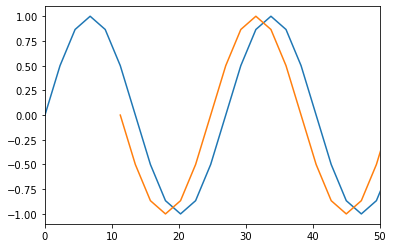

In [87]:
cycle_duration = 27 # (should be 27s)
hemi_freq = (1.0/cycle_duration) # of hemifield alternation, in hertz
n_trs_func = 139 # Length, in TRs, on a functional scan
total_len = n_trs_func*TR # seconds
Fs = 1/TR # Sampling freq
trs_exc_beg = 6
trs_exc_end = 1
nperseg = n_trs_func - trs_exc_beg - trs_exc_end

f_lb = 0.02
f_ub = 0.15

print(hemi_freq)

t = np.arange(0.0, total_len, TR)
t_trim = np.arange((trs_exc_beg-1)*TR, (total_len - trs_exc_beg - trs_exc_end)+1, TR)
hemifield_alternation_sinusoid = np.sin(hemi_freq*2*np.pi*t)
hemi_alt_trim = hemifield_alternation_sinusoid[trs_exc_beg:(-1*trs_exc_end)]
print(t, hemifield_alternation_sinusoid.shape)

fig, ax = plt.subplots(1)
ax.set_xlim(0, 50)
ax.plot(t, hemifield_alternation_sinusoid)
ax.plot(t_trim, hemi_alt_trim)

#### make brainmask if it doesn't exist already

In [ ]:
masker = NiftiMasker(detrend=False, standardize="psc", mask_strategy="epi", high_pass=f_lb, low_pass=f_ub, t_r=TR) # 

In [ ]:
masker.fit(bolds[0])

In [ ]:
print(mask_file)

In [ ]:
!ls {mask_file}

In [ ]:
masker.mask_img_.to_filename(mask_file)

In [ ]:
mask_img = masker.mask_img_
mask_img.shape

#### use niftimasker to extract timeseries from ROIs

In [ ]:
for roi in resampled_rois:
    
    masker = NiftiMasker(mask=roi, detrend=False, standardize="psc", high_pass=f_lb, low_pass=f_ub, t_r=TR) # 

#### average the runs

In [ ]:
mean_bold_timeseries = utils.average_timeseries(bolds, masker)

In [ ]:
mean_bold_timeseries.shape

In [ ]:
mean_bold_timeseries[:5, :5]

In [ ]:
hemi_ts = ts.TimeSeries(data=hemifield_alternation_sinusoid,
                         sampling_interval=TR)
hemi_ts_trim = ts.TimeSeries(data=hemi_alt_trim,
                         sampling_interval=TR)

In [ ]:
hemi_ts.shape, hemi_ts_trim.shape

In [ ]:
mean_bold_timeseries.shape

In [ ]:
trim_bold_nm = mean_bold_timeseries[trs_exc_beg:(-1*trs_exc_end),:] # note we are using the mean of the two runs
trim_bold_nm.shape

### begin coherence stuff

#### dummy stuff to see how coherence works

In [ ]:
timepad = np.pad(hemifield_alternation_sinusoid, (3,0), 'constant',
                 constant_values=(0,0))[:hemifield_alternation_sinusoid.shape[0]]
timepad2 = np.pad(hemifield_alternation_sinusoid, (6,0), 'constant',
                 constant_values=(0,0))[:hemifield_alternation_sinusoid.shape[0]]
timepad3 = np.pad(hemifield_alternation_sinusoid, (8,0), 'constant',
                 constant_values=(0,0))[:hemifield_alternation_sinusoid.shape[0]]

In [ ]:
fig, ax = plt.subplots(1)
ax.set_xlim(0, 50)
ax.plot(t, hemifield_alternation_sinusoid)
ax.plot(t, timepad)
ax.plot(t, timepad2)
ax.plot(t, timepad3)

#### analyze the real fmri data

In [ ]:
masked_ts_flat = trim_bold_nm.T # want nvox, n_tp so transpose NiftiMasker result
#demean_ts_flat = demean.T

In [ ]:
t=t_trim
print(t)
fig, ax = plt.subplots(1)
ax.set_xlim(0, 315)
ax.plot(t, hemi_alt_trim)
ax.plot(t, masked_ts_flat[32, :])
ax.plot(t, masked_ts_flat[3222, :])
ax.plot(t, masked_ts_flat[11513, :])
#ax.plot(t, masked_ts_flat[546434, :])

#### SpectralAnalyzer

In [ ]:
bold_flat = ts.TimeSeries(masked_ts_flat[:, :], sampling_interval=TR)
#bold_flat = ts.TimeSeries(demean_ts_flat[:, :], sampling_interval=TR)

In [ ]:
bold_flat.sampling_rate

In [ ]:
bold_flat.shape

In [ ]:
assert(nperseg == masked_ts_flat.shape[-1])

In [ ]:
S_original = nta.SpectralAnalyzer(bold_flat, method={'this_method':'welch', 'NFFT':nperseg, 'Fs':bold_flat.sampling_rate})

In [ ]:
print(S_original)

In [ ]:
def plot_spectra(S_original, voxid):
    fig01 = plt.figure()
    ax01 = fig01.add_subplot(1, 1, 1)
    ax01.plot(S_original.psd[0],
              S_original.psd[1][voxid],
              label='Welch PSD')
    print(S_original.psd[0], S_original.psd[1], len(S_original.psd[1]))

    ax01.plot(S_original.spectrum_fourier[0],
              np.abs(S_original.spectrum_fourier[1][voxid]),
              label='FFT')
    
    ax01.set_xlabel('Frequency (Hz)')
    ax01.set_ylabel('Power')

    ax01.legend()

In [ ]:
voxid = 144

In [ ]:
plot_spectra(S_original, voxid)

In [ ]:
masked_ts_flat.shape

In [ ]:
bold_flat.data.shape

In [ ]:
def comparison_plots(masked_ts_flat, S_original, Fs, nperseg, voxid=1000):
    # Compute PSD with `scipy.signal.welch`
    f_welch, S_welch = scipy.signal.welch(
        masked_ts_flat[voxid, :], fs=Fs, nperseg=nperseg, noverlap=(nperseg // 2),
        detrend=None, scaling='density', window='hanning')

    # Compute PSD with `matplotlib.mlab.psd`, using parameters that are
    # *equivalent* to those used in `scipy.signal.welch` above
    S_mlab, f_mlab = mlab.psd(
        masked_ts_flat[voxid, :], Fs=Fs, NFFT=nperseg, noverlap=(nperseg // 2),
        detrend=None, scale_by_freq=True, window=mlab.window_hanning)

    fig, axes = plt.subplots(3, 1, sharex=True)

    # Plot PSD computed via both methods
    axes[0].plot(f_welch, S_welch, label='scipy.signal.welch')
    axes[0].plot(f_mlab, S_mlab, label='mlab.psd')
    axes[0].set_ylabel('PSD')
    axes[0].legend()

    axes[1].plot(S_original.spectrum_fourier[0],
                  np.abs(S_original.spectrum_fourier[1][voxid]),
                  label='nitime FFT')

    freqs2 = nitime.utils.get_freqs(Fs, masked_ts_flat.shape[-1])
    fft = scipy.fftpack.fft(bold_flat.data)
    scaledAmp = np.abs(fft[:, :freqs2.shape[0]])
    amp = 2*scaledAmp/masked_ts_flat.shape[-1]
    sqrtsummagsq = np.sqrt(np.sum(scaledAmp[:, :]**2))
    print(sqrtsummagsq)
    co = scaledAmp[:,11]/sqrtsummagsq;

    axes[1].plot(freqs2, scaledAmp[voxid], label='ScaledAmp')
    axes[2].plot(freqs2, amp[voxid], label='Amp')
    axes[2].set_xlabel('f')
    axes[1].legend()
    axes[2].legend()

    plt.suptitle(f"voxid {voxid}, co {co[voxid]}")
    plt.show()
    
    return [freqs2, amp, co]

In [ ]:
for v in [155, 1555, 12224]:
    _ = comparison_plots(masked_ts_flat, S_original, Fs, nperseg, v)

In [ ]:
[f, a, co] = comparison_plots(masked_ts_flat, S_original, Fs, nperseg, 1000)

In [ ]:
plt.hist(co)

In [ ]:
coh_amp_map = masker.inverse_transform(co)

In [ ]:
coh_amp_map.to_filename(coh_fn)

#### Correlation and Coherence

In [ ]:
full_stim = np.vstack((hemifield_alternation_sinusoid, masked_ts_flat[:1000,:]))

In [ ]:
full_stim.shape

In [ ]:
test_ts = ts.TimeSeries(full_stim, sampling_interval=TR)

In [ ]:
cr1 = nta.CorrelationAnalyzer(test_ts)
print(cr1.corrcoef)
ntv.drawmatrix_channels(cr1.corrcoef, color_anchor=0)

In [ ]:
ch1 = nta.CoherenceAnalyzer(test_ts)
#physiologically relevant freq band
freq_idx = np.where((ch1.frequencies > 0.02) * (ch1.frequencies < 0.15))[0]
coh = np.mean(ch1.coherence[:,:,freq_idx], -1)
coh

In [ ]:
fig03 = ntv.drawmatrix_channels(coh)

In [ ]:
ch1.phase[0,1]

#### SeedCoherenceAnalyzer

In [ ]:
n_seeds = 1
A = nta.SeedCoherenceAnalyzer(hemi_ts_trim, bold_flat)#, method=dict(NFFT=32))
B = nta.SeedCorrelationAnalyzer(hemi_ts_trim, bold_flat)
freq_idx = np.where((A.frequencies > f_lb) * (A.frequencies < f_ub))[0]
#freq_idx_hemionly = np.where((np.isclose(A.frequencies, hemi_freq)))[0]
#print(freq_idx, freq_idx_hemionly)
print(A.frequencies, A.frequencies[freq_idx], f_lb, f_ub, sep="\n")
cor = []
coh = []

for this_seed in range(n_seeds):
    #print(this_seed, A.coherence[this_seed], A.coherence[this_seed][freq_idx])
    # Extract the coherence and average across these frequency bands:
    print(A.coherence.shape, A.coherence[:, :], A.coherence[:, freq_idx_hemionly], sep="\n")
    coh.append(np.mean(A.coherence[:, freq_idx], -1))  # Averaging on the last dimension
    cor.append(B.corrcoef[this_seed])  # No need to do any additional computation
        
print(f"coh: {coh}", f"cor: {cor}", sep="\n")

In [ ]:
len(coh[0])

In [ ]:
np.count_nonzero(coh[0])

#### Write coherence values to Nifti file

In [ ]:
coherence_img = masker.inverse_transform(coh[0])
coherence_img.shape

In [ ]:
print(coh_fn)

In [ ]:
coherence_img.to_filename(coh_fn)

In [ ]:
!ls "{coh_fn}"

In [ ]:
cmd = f"fsleyes {bolds[0]} {coh_fn}"

In [ ]:
os.system(cmd)

#### Some visualizations

In [ ]:
plt.hist(coh[0])

In [ ]:
plt.boxplot(coh[0])

In [ ]:
np.count_nonzero(coh[0]==0)

### Continue from here...

In [ ]:
lgn_coh_low = 0.17
lgn_coh_high = 0.19
lgn_voxel_mask_coh = np.logical_and((coh[0] > lgn_coh_low), (coh[0] < lgn_coh_high))

In [ ]:
np.count_nonzero(lgn_voxel_mask_coh)

## Assigning voxels within an ROI to M/P

In [ ]:
LP_roi, LM_roi = utils.assign_roi_percentile(rois[0], beta_MP, 20)

In [ ]:
RP_roi, RM_roi = utils.assign_roi_percentile(rois[1], beta_MP, 20)

## ROI plotting

In [ ]:
imgs_in_order = [RP_roi, RM_roi, beta_MP_img]
r = 5
c = 3
fig, ax = plt.subplots(nrows=r, figsize=(10,10))
img_data = [img.get_data() for img in imgs_in_order]
p_roi, m_roi, beta_mp = img_data
print([np.count_nonzero(x) for x in img_data])
p_roi_masked = np.ma.masked_where(p_roi==0, p_roi)
m_roi_masked = np.ma.masked_where(m_roi==0, m_roi)
p_mask = np.ma.getmask(p_roi_masked)
m_mask = np.ma.getmask(m_roi_masked)
both_mask = np.logical_and(p_mask,m_mask)
beta_masked = np.ma.masked_array(beta_mp, mask=both_mask)
print([np.count_nonzero(~m) for m in [p_mask, m_mask, both_mask]])
ref_vol_data = ref_vol_img.get_data()
for ri in range(r):
    #ax[ri].imshow(ref_vol_data[10:64,50:70,14-ri])
    pos = ax[ri].imshow(beta_masked[40:64,50:70,14-ri], cmap="cyan_orange")
    plt.colorbar(pos, ax=ax[ri])

In [ ]:
imgs_in_order = [LP_roi, LM_roi]
r = 5
c = 2
fig, ax = plt.subplots(nrows=r, ncols=c, figsize=(10,10))
img_data = [img.get_data() for img in imgs_in_order]
img_data_masked = [np.ma.masked_where(img==0, img) for img in img_data]
ref_vol_data = ref_vol_img.get_data()
    #plot_roi(imgdata[slice(70,80), slice(55,65), slice(10,15)])
for ri in range(r):
    for ci in range(c):
        ax[ri, ci].imshow(ref_vol_data[64:-20,:,14-ri])
        ax[ri, ci].imshow(img_data_masked[ci][64:-20,:,14-ri], cmap="binary")

In [ ]:
imgs_in_order=[RP_roi, RM_roi]
r = 5
c = 2
fig, ax = plt.subplots(nrows=r, ncols=c, figsize=(10,10))
img_data = [img.get_data() for img in imgs_in_order]
img_data_masked = [np.ma.masked_where(img==0, img) for img in img_data]
ref_vol_data = ref_vol_img.get_data()
    #plot_roi(imgdata[slice(70,80), slice(55,65), slice(10,15)])
for ri in range(r):
    for ci in range(c):
        ax[ri, ci].imshow(ref_vol_data[10:64,:,14-ri])
        ax[ri, ci].imshow(img_data_masked[ci][10:64,:,14-ri], cmap="binary")

In [ ]:
def view_copes(datasink, contrasts, **kwargs):
    l1copes, l2copes = utils.get_model_outputs(datasink, contrasts)
    return nilearn.plotting.view_img(l2copes[0], **kwargs)

In [ ]:
view_copes(mp_datasink, [3], bg_img=ref_vol_path, threshold="90%", vmax=3, cut_coords=cut)

In [ ]:
def plot_lgn(datasink, contrasts, **kwargs):
    l1copes, l2copes = utils.get_model_outputs(datasink, contrasts)
    return nilearn.plotting.plot_img(l2copes[0], **kwargs)

In [ ]:
plot_lgn(mp_datasink, [3], threshold=2, cut_coords=cut, bg_img=ref_vol_path)

In [ ]:
view_copes(hemi_datasink, [3], bg_img=ref_vol_path, threshold=2, vmax=5, cut_coords=(-17, -3, 1))

In [ ]:
LP_roi.get_data().shape

In [ ]:
roi_fig = plt.figure(figsize=(10, 5))
plot_roi(LP_roi, bg_img=ref_vol_path, display_mode='x',
         cut_coords=range(-23, -14), cmap=plt.get_cmap("brown_cyan"),
        figure=roi_fig)
roi_fig2 = plt.figure(figsize=(10, 5))
plot_roi(LP_roi, bg_img=anat_file, display_mode='x',
         cut_coords=range(-23, -14), cmap=plt.get_cmap("brown_cyan"),
        figure=roi_fig2)

In [ ]:
plot_roi(LP_roi, bg_img=ref_vol_path, cut_coords=cut)